In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/g2net-hackathon/classification_training_data.npz
/kaggle/input/g2net-hackathon/classification_validation_data.npz
/kaggle/input/g2net-hackathon/sample_submission.csv
/kaggle/input/g2net-hackathon/classification_test_data.npz


In [2]:
import numpy as np
import pandas as pd
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam
from torch import nn
from torchmetrics.classification.accuracy import MulticlassAccuracy

import pylab

First let's set the random seed, so that we always get the same results when running the code.
Remember, this isn't a hyperparameter, we aren't looking for the lotto ticket number.

In [3]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(0)

We need to define a torch.utils.data.Dataset type that reads our raw data and returns a (sample, label) tuple for each sample.

In [4]:
class WaveformDataset(Dataset):
    def __init__(self, npz_file, test=False):
        df = np.load(npz_file)
        self.foregrounds = df['foreground']
        self.n_samples = self.foregrounds.shape[0]
        print(f'Total number of samples: {self.n_samples}')
        self.test = test
        if not self.test:
            # we don't have labels available for the test set
            self.labels = df['label'][:self.n_samples]

    def __len__(self):
        return self.n_samples

    def __getitem__(self, item):
        fg = np.asarray(self.foregrounds[item, :])
        if self.test:
            return torch.from_numpy(fg)

        label = np.asarray(self.labels[item])
        return torch.from_numpy(fg), label

train_dataset = WaveformDataset('/kaggle/input/g2net-hackathon/classification_training_data.npz')
val_dataset = WaveformDataset('/kaggle/input/g2net-hackathon/classification_validation_data.npz')

Total number of samples: 10000
Total number of samples: 2000


Time to create our network architecture. 
Can you think of any reason not to use only nn.Linear layers? What about only nn.Conv1d layers?
Can the nn.MaxPool1d layers be replaced with other types of layers that equivalently reduce the temporal dimension?
What about the non-linearities?

In [5]:
network = nn.Sequential(  # Shapes
    nn.BatchNorm1d(1),  # 1x2048
    nn.Conv1d(1, 4, 64),  # 4x1985
    nn.ELU(),  # 4x1985
    nn.Conv1d(4, 4, 32),  # 4x1954
    nn.MaxPool1d(4),  # 4x 489
    nn.ELU(),  # 4x 489
    nn.Conv1d(4, 8, 32),  # 8x 458
    nn.ELU(),  # 8x 458
    nn.Conv1d(8, 8, 16),  # 8x 443
    nn.MaxPool1d(3),  # 8x 147
    nn.ELU(),  # 8x 147
    nn.Conv1d(8, 16, 16),  # 16x 132
    nn.ELU(),  # 16x 132
    nn.Conv1d(16, 16, 16),  # 16x 117
    nn.MaxPool1d(4),  # 16x  29
    nn.ELU(),  # 16x  29
    nn.Flatten(),  # 464
    nn.Linear(464, 32),  # 32
    nn.Dropout(p=0.5),  # 32
    nn.ELU(),  # 32
    nn.Linear(32, 16),  # 16
    nn.Dropout(p=0.5),  # 16
    nn.ELU(),  # 16
    nn.Linear(16, 3),  # 2
    nn.Softmax(dim=1)  # 2
)
print(network)
# HINT: https://pytorch.org/docs/stable/nn.init.html
# https://stackoverflow.com/a/49433937

Sequential(
  (0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv1d(1, 4, kernel_size=(64,), stride=(1,))
  (2): ELU(alpha=1.0)
  (3): Conv1d(4, 4, kernel_size=(32,), stride=(1,))
  (4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (5): ELU(alpha=1.0)
  (6): Conv1d(4, 8, kernel_size=(32,), stride=(1,))
  (7): ELU(alpha=1.0)
  (8): Conv1d(8, 8, kernel_size=(16,), stride=(1,))
  (9): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (10): ELU(alpha=1.0)
  (11): Conv1d(8, 16, kernel_size=(16,), stride=(1,))
  (12): ELU(alpha=1.0)
  (13): Conv1d(16, 16, kernel_size=(16,), stride=(1,))
  (14): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (15): ELU(alpha=1.0)
  (16): Flatten(start_dim=1, end_dim=-1)
  (17): Linear(in_features=464, out_features=32, bias=True)
  (18): Dropout(p=0.5, inplace=False)
  (19): ELU(alpha=1.0)
  (20): Linear(in_features=32, out_featur

Let's define some hyperparameters and load our datasets.
What happens when you try different optimizers? What about different learning rates or batch sizes?
Remember, a tried and true strategy regarding the learning rate is to reduce it as training progresses.
Are there other loss functions that can be used instead of nn.CrossEntropyLoss?

In [6]:
device = 'cuda:0'
network = network.to(device)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=device)
val_dataloader = DataLoader(val_dataset, batch_size=128, num_workers=2, pin_memory=device)
n_epochs = 10
lr = 5e-5
optimizer = Adam(network.parameters(), lr=lr)
# HINT: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html
loss = nn.CrossEntropyLoss()

train_losses = np.zeros((n_epochs,))
train_accs = np.zeros((n_epochs,))
val_losses = np.zeros((n_epochs,))
val_accs = np.zeros((n_epochs,))

acc_metric = MulticlassAccuracy(num_classes=3, average='none').to(device)

Ready for our training loop.
Remember, in mini-btach gradient descent, we say one epoch has passed when the network has seen the training set in its entirety.
An iteration is when we pass a single mini-batch through the network, compute the loss and gradients, and update the weights.

In [7]:
for ep in range(n_epochs):
    network.train()
    training_loss = 0.
    training_correct = 0
    training_total = 0
    for i, (x, y) in enumerate(train_dataloader):
        # unsqueeze is needed here to add a channel dimension so we can use convolutional layers
        x = x.unsqueeze_(1).to(dtype=torch.float32).to(device)
        y = y.to(dtype=torch.long).to(device)

        optimizer.zero_grad()

        p = network(x)
        l = loss(p, y)

        l.backward()
        # HINT: https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html
        optimizer.step()
        
        training_loss += l.item()
        # we need to convert the one-hot predictions into (0, 1, 2) labels to measure accuracy
        _, p_c = p.max(1)
        training_correct += p_c.eq(y).sum().item()
        training_total += x.size(0)

    train_losses[ep] = training_loss / (i + 1)
    train_accs[ep] = 100 * training_correct/training_total
    print(f'Epoch {ep} | Training   | Loss {train_losses[ep]:3.2f} |'
          f' Acc {train_accs[ep]:5.2f}% ')

    network.eval()  # this line sets the network to evaluation mode (e.g., do not compute gradients, or mean and std for batch normalization layers)
    validation_loss = 0.
    validation_correct = 0.
    validation_total = 0.
    val_preds = []
    val_gt = []
    with torch.no_grad():
        for i, (x, y) in enumerate(val_dataloader):
            x = x.unsqueeze_(1).to(dtype=torch.float32).to(device)
            y = y.to(dtype=torch.long).to(device)
            p = network(x)
            l = loss(p, y)
            # no backward pass for validation set
            validation_loss += l.item()
            _, p_c = p.max(1)
            val_preds.extend(p_c)
            val_gt.extend(y)
            validation_correct += p_c.eq(y).sum().item()
            validation_total += x.size(0)
        val_losses[ep] = validation_loss / (i + 1)
        val_accs[ep] = 100 * validation_correct / validation_total
        val_acc_per_class = acc_metric(torch.stack(val_preds), torch.stack(val_gt))
        print(f'Epoch {ep} | Validation | Loss {val_losses[ep]:3.2f} |'
              f' Acc {val_accs[ep]:5.2f}% (0:{val_acc_per_class[0]:5.2f} 1:{val_acc_per_class[1]:5.2f} 2:{val_acc_per_class[2]:5.2f})')

Epoch 0 | Training   | Loss 1.10 | Acc 35.19% 
Epoch 0 | Validation | Loss 1.10 | Acc 34.65% (0: 1.00 1: 0.00 2: 0.00)
Epoch 1 | Training   | Loss 1.10 | Acc 36.58% 
Epoch 1 | Validation | Loss 1.10 | Acc 34.65% (0: 1.00 1: 0.00 2: 0.00)
Epoch 2 | Training   | Loss 1.09 | Acc 38.20% 
Epoch 2 | Validation | Loss 1.09 | Acc 41.00% (0: 1.00 1: 0.00 2: 0.18)
Epoch 3 | Training   | Loss 0.97 | Acc 60.20% 
Epoch 3 | Validation | Loss 0.90 | Acc 62.25% (0: 0.83 1: 0.04 2: 0.91)
Epoch 4 | Training   | Loss 0.89 | Acc 65.85% 
Epoch 4 | Validation | Loss 0.85 | Acc 68.85% (0: 0.88 1: 0.25 2: 0.88)
Epoch 5 | Training   | Loss 0.86 | Acc 68.76% 
Epoch 5 | Validation | Loss 0.83 | Acc 71.20% (0: 0.92 1: 0.35 2: 0.81)
Epoch 6 | Training   | Loss 0.85 | Acc 69.45% 
Epoch 6 | Validation | Loss 1.20 | Acc 34.95% (0: 1.00 1: 0.00 2: 0.01)
Epoch 7 | Training   | Loss 0.84 | Acc 71.24% 
Epoch 7 | Validation | Loss 0.82 | Acc 72.20% (0: 0.92 1: 0.43 2: 0.77)
Epoch 8 | Training   | Loss 0.83 | Acc 72.20% 
E

Let's visualize the training progress in terms of train/val loss/accuracy.
What do these curves tell us about which hyperparameters we should change?
Remember, change only one hyperparameter at a time, but write down all of them.

Text(0.5, 0, 'Epochs')

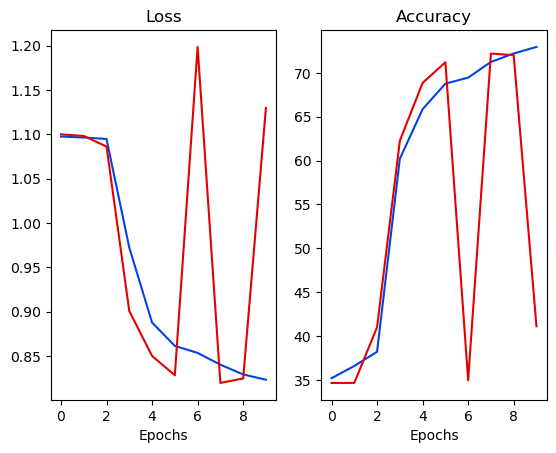

In [8]:
fig, axs = pylab.subplots(1, 2, sharex=True)
axs[0].plot(train_losses, label='train', color='xkcd:blue')
axs[0].plot(val_losses, label='val', color='xkcd:red')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')

axs[1].plot(train_accs, label='train', color='xkcd:blue')
axs[1].plot(val_accs, label='val', color='xkcd:red')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')

Time to run our network on the test data. We only have the input timeseries available (not the labels), so we need a slightly modified loop.

In [9]:
print('Running network on test data...')
test_dataset = WaveformDataset('/kaggle/input/g2net-hackathon/classification_test_data.npz', test=True)
# IMPORTANT: do NOT shuffle test set
test_dataloader = DataLoader(test_dataset, batch_size=128, num_workers=8, pin_memory=device, shuffle=False)
network.eval()
test_preds = []
test_gt = []
with torch.no_grad():
    for i, x in enumerate(test_dataloader):
        x = x.unsqueeze_(1).to(dtype=torch.float32).to(device)
        p = network(x)
        
        _, p_c = p.max(1)
        test_preds.extend(p_c.cpu().numpy())
# write result to csv
df = pd.DataFrame({'Category': np.asarray(test_preds)})
df.index.name = 'Id'
df.to_csv('classification_test_predictions.csv')

Running network on test data...
Total number of samples: 10000


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
